# Problem statement

To improve the efficiency of taxi dispatching systems for taxi services, it is important to be able to predict the duration of the ride by a particular driver. This improves the pickup and drop requests to greater heights. Here in this problem, we have to build a model that predicts the toal ride duration of taxi trips in new york city.

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('nyc_taxi_trip_duration.csv')

In [3]:
print("rows=",df.shape[0])
print("columns=",df.shape[1])

rows= 729322
columns= 11


In [4]:
#to get the column names
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


# EDA

According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

In [6]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

The correct datatype for time is not allotted, we convert them using datetime.

In [7]:
df['pickup_datetime']=pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime']=pd.to_datetime(df.dropoff_datetime)

Converting flags to 1 and 0

In [8]:
df['store_and_fwd_flag']=1*(df.store_and_fwd_flag=='Y')

In [9]:
df['check_trip_duration']=(df['dropoff_datetime']-df['pickup_datetime']).map(lambda x:x.total_seconds())

In [10]:
duration_difference=df[np.abs(df['check_trip_duration'].values-df['trip_duration'].values)>1]

In [11]:
duration_difference.shape

(0, 12)

Implies that there is no inconsistency in data wrt the drop location and trip duration

Since our target variable is trip duration, lets explore that.

In [12]:
df['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

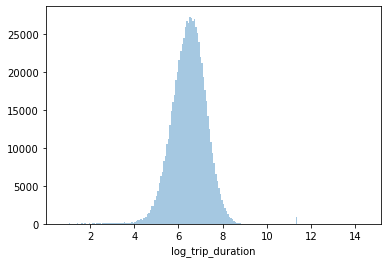

In [13]:
df['log_trip_duration']=np.log(df['trip_duration'].values+1)
sns.distplot(df['log_trip_duration'],kde=False,bins=200)
plt.show()

Text(0, 0.5, 'Frequency')

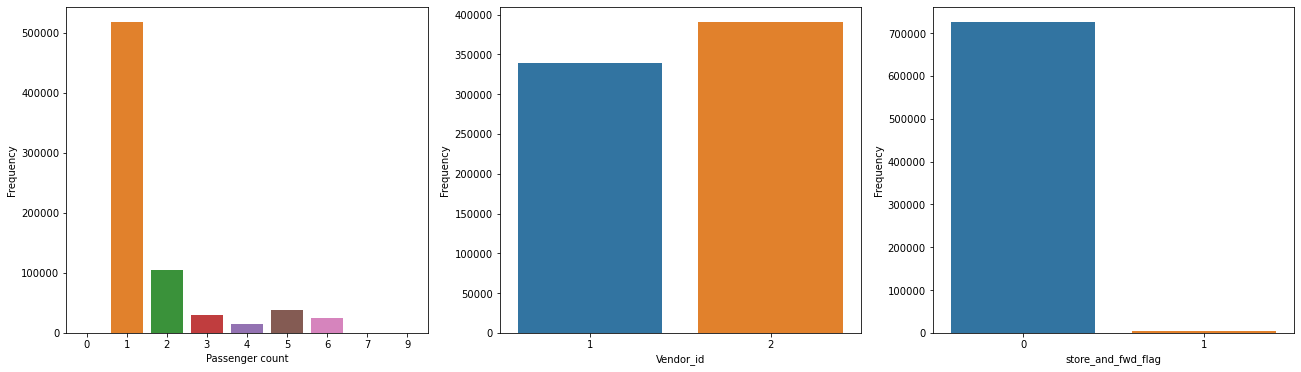

In [14]:
plt.figure(figsize=(22,6))
plt.subplot(1,3,1)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger count')
plt.ylabel('Frequency')
plt.subplot(1,3,2)
sns.countplot(df['vendor_id'])
plt.xlabel('Vendor_id')
plt.ylabel('Frequency')
plt.subplot(1,3,3)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')

# Inference
1. Most of the trips involve 1 passenger only. Trips involving 7 and 9 passengers are present but frequency is less
2. Vendor 2 had more trips than vendor 1
3. Third plot shows that most of the trips data was sent immediately to vendor. 

In [15]:
#To find the timeline of the data
df['pickup_datetime'].min(),df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

To analyse more effeciently, we try to look into data daywise.

In [16]:
df['day_of_week']=df['pickup_datetime'].dt.weekday
df['hour_of_day']=df['pickup_datetime'].dt.hour

Text(0, 0.5, 'Total no of pickups')

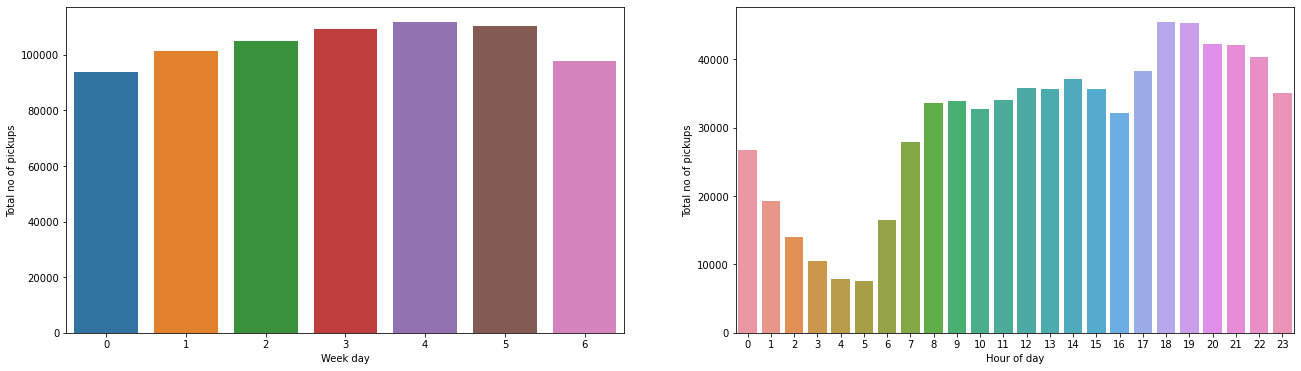

In [17]:
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
sns.countplot(df['day_of_week'])
plt.xlabel('Week day')
plt.ylabel('Total no of pickups')
plt.subplot(1,2,2)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of day')
plt.ylabel('Total no of pickups')

* Here we can observe that pickups are lower in weekends and peak at thursday(day 4). Sunday is 0 and 6 is saturday
* No of pickups as expected is highest in late evenings. It is also lower during morning peak hours

In the data, we are given with coordinates of location of pickup and drop. Since the data deals with single city data, all the points should coincide with one point on plot. There shouldnt be much variation in the data.

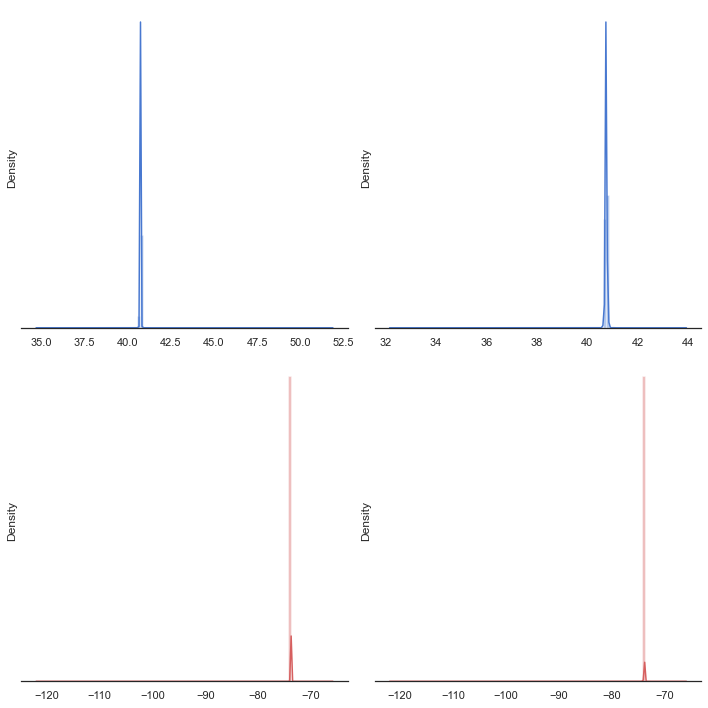

In [18]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Here we can see that pick and drop latitude are centred around 40 to 41 and longitude around -74 to -73 latitudes. 
There are few outliers in the data which we can see which has to be removed for better analysis

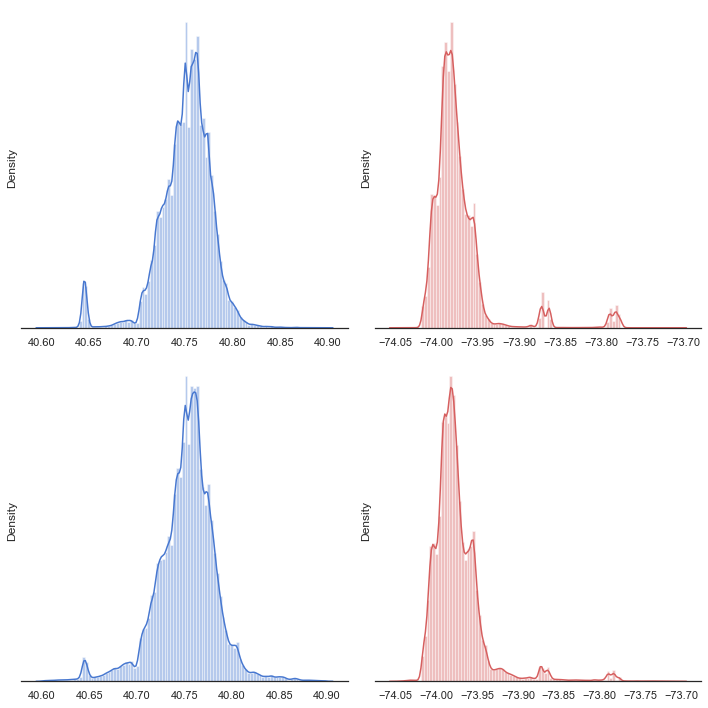

In [19]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

Here we get much better view of the data required.

Now, lets see their relations with target variable and understand the nature

In [20]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'day_of_week', 'hour_of_day'],
      dtype='object')

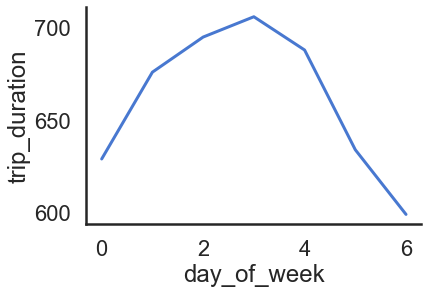

In [25]:
summary_wdays_avg_duration=pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace=True)
summary_wdays_avg_duration['unit']=1
sns.set(style='white',palette='muted',color_codes=True)
sns.set_context('poster')
sns.lineplot(data=summary_wdays_avg_duration,x='day_of_week',y='trip_duration')
sns.despine(bottom=False)

Since tsplot is discontinued since Jan 2020, alternative is using lineplot().

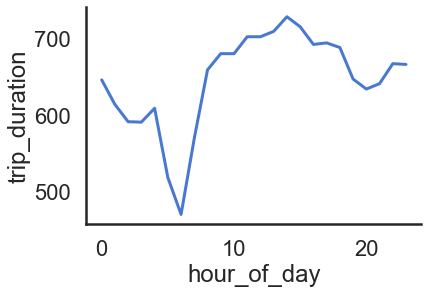

In [26]:
sum_hourly_avg=pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
sum_hourly_avg.reset_index(inplace=True)
sum_hourly_avg['unit']=1
sns.set(style='white',palette='muted',color_codes=True)
sns.set_context('poster')
sns.lineplot(x='hour_of_day',y='trip_duration',data=sum_hourly_avg)
sns.despine(bottom=False)

Here the trip durations are relatively shorter for late nights and early mrngs might be due to low traffic densities.

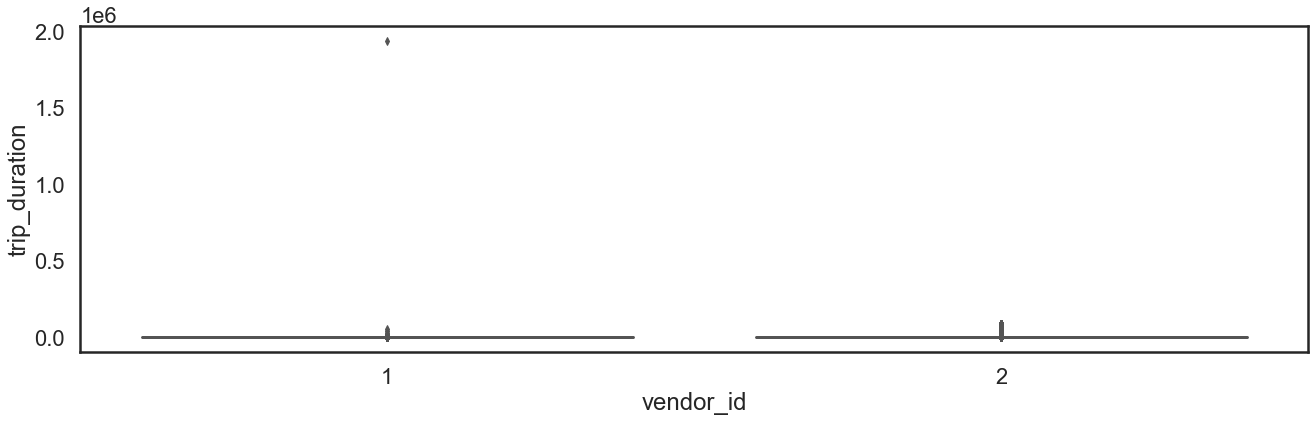

In [27]:
plt.figure(figsize=(22,6))
sns.boxplot(x='vendor_id',y='trip_duration',data=df)
plt.show()

We can observe from these box plots is that, vendor 2 has outliers exceeding 24 hours whereas vendor 1 doesnt have any long trips
To solve these outliers problem, We can either remove the huge outlier and plot again or look at median trip duration for both vendors on hourly basis

Sol 1:

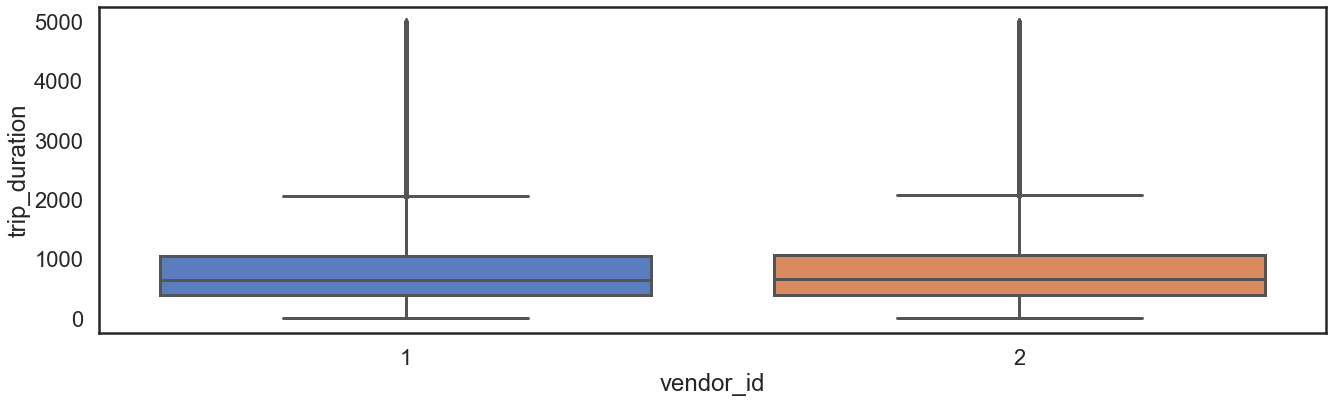

In [28]:
plt.figure(figsize=(22,6))
df_sub=df[df['trip_duration']<5000]
sns.boxplot(x='vendor_id',y='trip_duration',data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

## Mean trip duration vendorwise

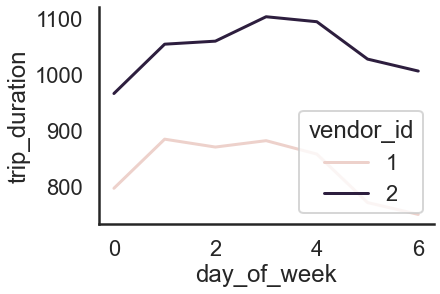

In [30]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration,x="day_of_week",hue="vendor_id", y="trip_duration")
sns.despine(bottom = False)

## Median trip duration vendorwise

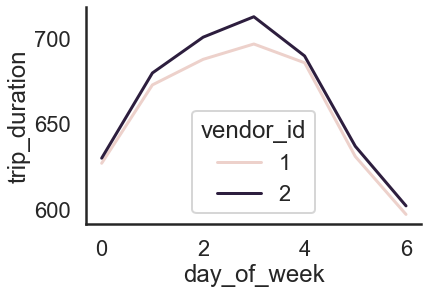

In [31]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue="vendor_id", y="trip_duration")
sns.despine(bottom = False)

Here the median trip duration doesnt vary much. 

# Trip duration v/s passenger count

In [32]:
df.passenger_count.value_counts()

1    515243
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

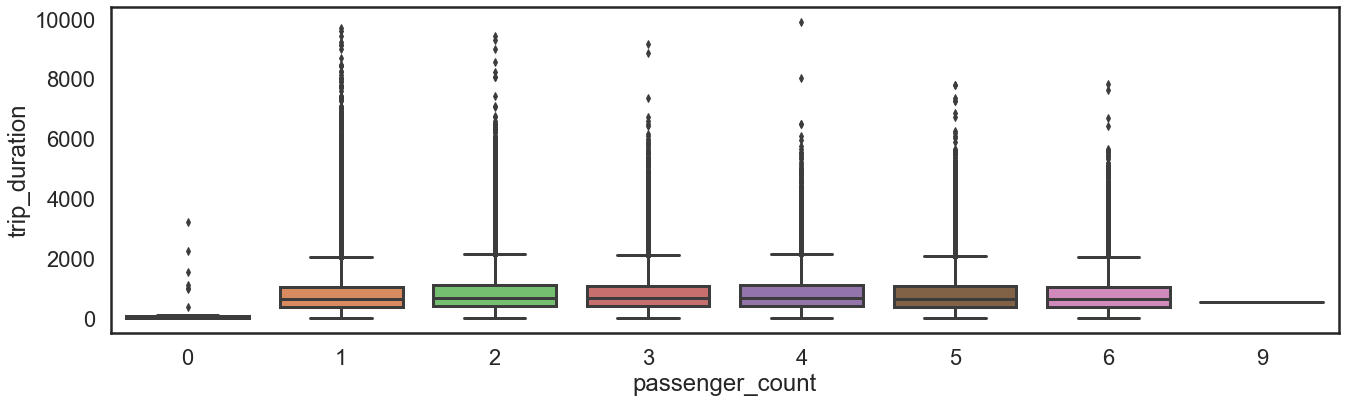

In [33]:
df.passenger_count.value_counts()
plt.figure(figsize=(22,6))
df_sub=df[df['trip_duration']<10000]
sns.boxplot(x='passenger_count',y='trip_duration',data=df_sub)
plt.show()

## Visualise most frequently occuring pickup points on the lattitude longitude map

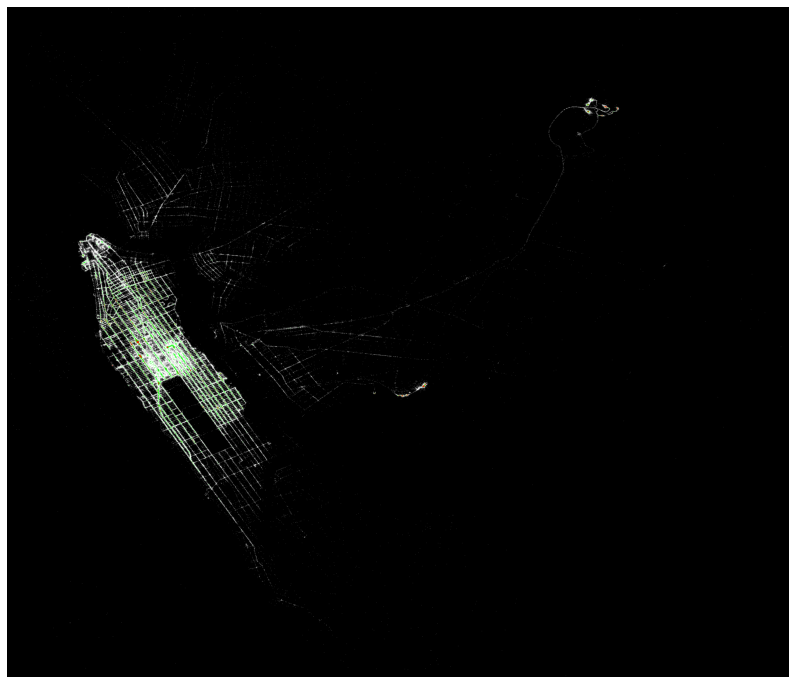

In [34]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

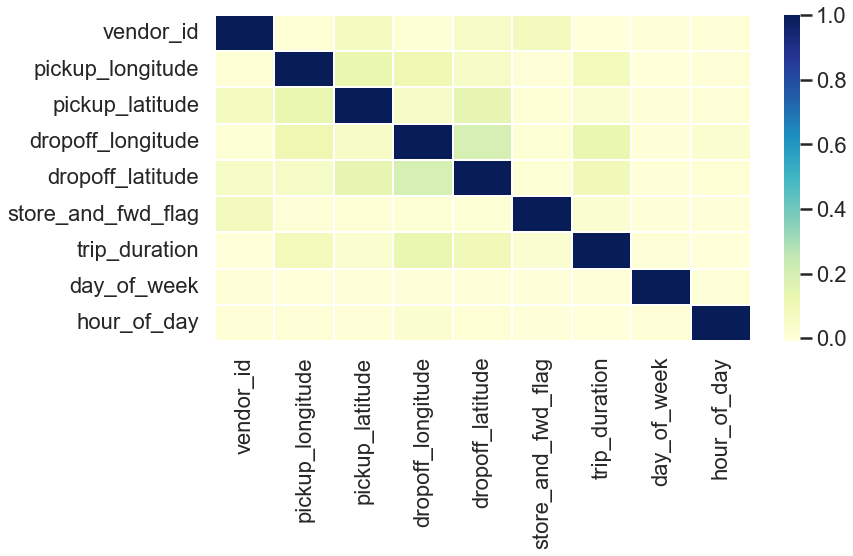

In [35]:
plt.figure(figsize=(12, 6))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

#### Conclusion
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

In [40]:
df=pd.read_csv('nyc_taxi_final.zip')

In [41]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [42]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

In [43]:

#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5

#### Haverine distance
It determines the distance of two points in a sphere. Considering the earth to be a sphere, we do haverine formula calucation. 

In [44]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

Since dataframe is slow. We use our user defined function taken from source.

In [45]:
df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)

### Fastest route by road
Sometimes, adding external information can be crucial for improving the model. Here we will use data extracted from The Open Source Routing Machine or OSRM for each trip in our original dataset. OSRM is a C++ implementation of a high-performance routing engine for shortest paths in road networks. This will give us a very good estimate of distances between pickup and dropoff Points

Source: http://project-osrm.org/

In [46]:
fr1 = pd.read_csv('fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


### Binning
Since the longitudes and latitudes are very close, its better to bin them for easier job.

In [47]:
df['pickup_latitude_rounded3']=np.round(df['pickup_latitude'],3)
df['pickup_longitude_rounded3']=np.round(df['pickup_longitude'],3)
df['dropoff_latitude_rounded3']=np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_rounded3']=np.round(df['dropoff_longitude'],3)

### one hot encoding

In [48]:
df.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

In [49]:
df['vendor_id']=df['vendor_id']-1

In [50]:
df.isnull().sum()

id                            0
vendor_id                     0
pickup_datetime               0
dropoff_datetime              0
passenger_count               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
store_and_fwd_flag            0
trip_duration                 0
pickup_weekday                0
pickup_hour_weekofyear        0
pickup_hour                   0
pickup_minute                 0
pickup_dt                     0
pickup_week_hour              0
dist_sq                       0
dist_sqrt                     0
haversine_distance            0
direction                     0
total_distance                1
total_travel_time             1
pickup_latitude_rounded3      0
pickup_longitude_rounded3     0
dropoff_latitude_rounded3     0
dropoff_longitude_rounded3    0
dtype: int64

In [51]:
df.fillna(0,inplace=True)

In [52]:
df=df.drop(['id','pickup_datetime','dropoff_datetime','trip_duration','store_and_fwd_flag'],axis=1)

In [53]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,...,dist_sq,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_rounded3,pickup_longitude_rounded3,dropoff_latitude_rounded3,dropoff_longitude_rounded3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,...,0.000159,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,...,0.001397,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,...,0.005287,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,...,0.000461,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,...,0.001872,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


In [54]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [55]:
xtrain,xtest,ytrain,ytest=tts(df,df_y,test_size=0.33,random_state=0)

In [56]:
mean_pred=np.repeat(ytrain.mean(),len(ytest))
sqrt(mse(ytest,mean_pred))

0.7986127904794492

### cross validation for improving performance of the model

In [65]:
def cv_score(model,rstate=11,cols=df.columns):
    i=1
    cv_scores=[]
    df1=df.copy()
    df2=df[cols]
    kf=KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl=df1.loc[train_index],df1.loc[test_index]
        ytr,yvl=df_y[train_index],df_y[test_index]
        model.fit(xtr,ytr)
        train_val=model.predict(xtr)
        pred_val=model.predict(xvl)
        rmse_score_train=sqrt(mse(ytr,train_val))
        rmse_score_test=sqrt(mse(yvl,pred_val))
        suffix=""
        msg=""
        msg+="Valid RMSE:{:.5f}".format(rmse_score_test)
        print("{}".format(msg))
        cv_scores.append(rmse_score_test)
        i+=1
    return cv_scores

### Linear regression

In [66]:
linreg_scores=cv_score(LinearRegression())


1 of kfold 5
Valid RMSE:0.54881

2 of kfold 5
Valid RMSE:0.54975

3 of kfold 5
Valid RMSE:0.54520

4 of kfold 5
Valid RMSE:0.56114

5 of kfold 5
Valid RMSE:0.54677


In [67]:
dtrees_scores=cv_score(DecisionTreeRegressor(min_samples_leaf=25,min_samples_split=25))


1 of kfold 5
Valid RMSE:0.42680

2 of kfold 5
Valid RMSE:0.42943

3 of kfold 5
Valid RMSE:0.41980

4 of kfold 5
Valid RMSE:0.42660

5 of kfold 5
Valid RMSE:0.42162


In [68]:
results_df=pd.DataFrame({'linear_regression':linreg_scores,'dtree':dtrees_scores})

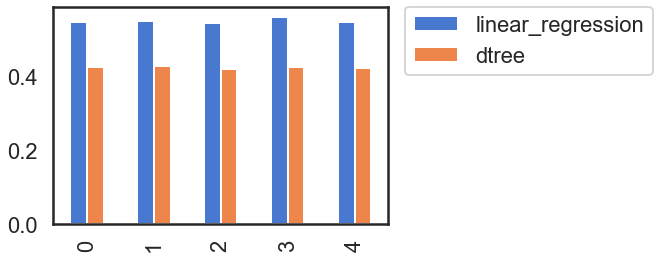

In [69]:
results_df.plot(y=['linear_regression',"dtree"],kind='bar',legend=False)
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()